<a href="https://colab.research.google.com/github/Aiden-Ross-Dsouza/Natural-Language-Processing-IvLabs/blob/master/image_caption_generation/notebooks/Image_Captioning_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dataset from Kaggle into Colab's Session Storage

In [ ]:
#Reference: https://github.com/nunenuh/imgcap.pytorch/blob/main/icap/data.py

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 99% 1.03G/1.04G [00:08<00:00, 143MB/s]
100% 1.04G/1.04G [00:09<00:00, 124MB/s]


# Extracting dataset from zipped folder

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flickr8k.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Importing Required Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import PIL
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader,Dataset

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from torchvision import transforms

import nltk
nltk.download('punkt')  # Download the tokenizer data
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

# Vocabulary

In [ ]:
# spacy_eng = spacy.load('en_core_web_sm')
class Vocabulary(object):
    def __init__(self, freq_threshold, spacy_eng=None):
        self.start_word = "<SOS>"
        self.end_word = "<EOS>"
        self.pad_word = "<PAD>"
        self.unk_word = "<UNK>"

        self.itos = {0: self.pad_word, 1: self.start_word, 2: self.end_word, 3: self.unk_word}
        self.stoi = {self.pad_word: 0, self.start_word: 1, self.end_word: 2, self.unk_word: 3}

        self.freq_threshold = freq_threshold
        if spacy_eng==None:
            self.spacy_eng = spacy.load('en_core_web_sm')
        else:
            self.spacy_eng = spacy_eng

    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        tokenizer = [tok.text.lower() for tok in self.spacy_eng.tokenizer(text)]
        return tokenizer

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# Dataset

In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_file, caption_delimiter=',',
                 image_column='image', text_column='caption',
                 transform=None, freq_threshold=5,
                 split='train', split_val=0.2, split_test=0.1):
        self.root_dir = root_dir
        self.caption_file = caption_file
        self.caption_delimiter = caption_delimiter
        self.image_column = image_column
        self.text_column = text_column

        self.dataframe = pd.read_csv(caption_file, delimiter=caption_delimiter)
        self.transform = transform

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.dataframe[self.text_column].tolist())

        self.split = split
        self.split_val = split_val
        self.split_test = split_test
        self._do_split_train_valid_test()

    def _do_split_train_valid_test(self):
        # Split into train+valid and test
        df_train_valid, df_test = train_test_split(
            self.dataframe, test_size=self.split_test, random_state=16)

        # Further split train+valid into train and valid
        df_train, df_valid = train_test_split(
            df_train_valid, test_size=self.split_val / (1 - self.split_test), random_state=16)

        if self.split == 'train':
            self.imgs = df_train[self.image_column]
            self.captions = df_train[self.text_column]
        elif self.split == 'valid':
            self.imgs = df_valid[self.image_column]
            self.captions = df_valid[self.text_column]
        elif self.split == 'test':
            self.imgs = df_test[self.image_column]
            self.captions = df_test[self.text_column]

        self.imgs = self.imgs.tolist()
        self.captions = self.captions.tolist()

    def __len__(self):
        return len(self.imgs)

    def _numericalized_caption(self, caption):
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return numericalized_caption

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        ncaption = self._numericalized_caption(caption)

        return img, torch.tensor(ncaption)

# Data Loader

In [ ]:
class CaptionCollate:
    def __init__(self, pad_idx, batch_first=True):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        batch.sort(key=lambda x: len(x[1]), reverse=True)
        (images, captions) = zip(*batch)

        imgs = [img.unsqueeze(0) for img in images]
        imgs = torch.cat(imgs, dim=0)

        lengths = [len(cap) for cap in captions]
        targets = torch.zeros(len(captions), max(lengths)).long()
        for idx, cap in enumerate(captions):
            end = lengths[idx]
            targets[idx, :end] = cap[:end]
        return imgs, targets, lengths

In [ ]:
def flickr_dataloader(root_folder, caption_file, transform, split='train',
                      batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_folder, caption_file, transform=transform, split=split)
    PAD_IDX = dataset.vocab.stoi["<PAD>"]
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers,
                            shuffle=shuffle if split == 'train' else False, pin_memory=pin_memory,
                            collate_fn=CaptionCollate(pad_idx=PAD_IDX))

    return dataloader, dataset

# Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, embed_size, train_cnn=False, resnet_model=models.resnet50):
        super(Encoder, self).__init__()
        self.train_cnn = train_cnn
        resnet = resnet_model(pretrained=True)
        resnet = self._fine_tune(resnet)
        modules = list(resnet.children())[:-1]

        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def _fine_tune(self, resnet):
        if self.train_cnn:
            for param in resnet.parameters():
                param.requires_grad_(True)
        else:
            for param in resnet.parameters():
                param.requires_grad_(False)

        return resnet

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        embed = self.bn(self.embed(features))
        return embed


class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

        self._init_weights()

    def _init_weights(self):
        torch.nn.init.xavier_uniform_(self.linear.weight)
        torch.nn.init.xavier_uniform_(self.embed.weight)

    def forward(self, features, captions, lengths):
        features = features.unsqueeze(dim=1)

        embeddings = self.embed(captions)
        embeddings = torch.cat((features, embeddings), dim=1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def caption_image(self, features, vocab, max_length=50):
        result_caption = []

        states = None
        for _ in range(max_length):
            hiddens, states = self.lstm(features.unsqueeze(1), states)
            output = self.linear(hiddens.squeeze(1))
            predicted = output.argmax(1)
            result_caption.append(predicted.item())
            features = self.embed(predicted)

            if vocab.itos[predicted.item()] == "<EOS>":
                break

        return [vocab.itos[idx] for idx in result_caption]

class ImageCaptionNet(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptionNet, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers

        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs

# Train

In [ ]:
def train_model(model, dataloader, criterion, optimizer, num_epochs, device):
    model.train()
    model.to(device)

    losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        for idx, (images, captions, lengths) in enumerate(tqdm(dataloader)):
            images, captions = images.to(device), captions.to(device)
            optimizer.zero_grad()
            outputs = model(images, captions, lengths)

            packed = pack_padded_sequence(captions, lengths, batch_first=True)
            targets, _ = packed.data, packed.batch_sizes

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            losses.append(loss.item())

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(dataloader)}')

    return losses

# Hyperparameters

In [ ]:
root_folder = '/content/Images'
caption_file = '/content/captions.txt'

transform = transforms.Compose(
      [
          transforms.Resize((356,356)), #This transformation resizes the input image to a fixed size of 356x356 pixels. Resizing ensures that all images are of the same size, which is necessary for batch processing in neural networks.
          transforms.RandomCrop((299,299)), #This transformation randomly crops a 299x299 patch from the resized image. Random cropping is a form of data augmentation that helps improve the robustness of the model by exposing it to different parts of the images during training.
          transforms.ToTensor(),
          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #This transformation normalizes the pixel values of the image. The mean and standard deviation for each channel (RGB) are set to 0.5. Normalization is important because it helps stabilize and accelerate the training process by ensuring that the pixel values have a consistent distribution.
      ]
  )

# Create DataLoaders
train_loader, train_dataset = flickr_dataloader(root_folder, caption_file, transform, split='train', batch_size=32)
valid_loader, valid_dataset = flickr_dataloader(root_folder, caption_file, transform, split='valid', batch_size=32)
test_loader, test_dataset = flickr_dataloader(root_folder, caption_file, transform, split='test', batch_size=32)

embed_size = 256
hidden_size = 512
vocab_size = len(train_dataset.vocab)
num_layers = 1

model = ImageCaptionNet(embed_size, hidden_size, vocab_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

num_epochs = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/util

Epoch [1/6], Loss: 3.477611395464105


100%|██████████| 885/885 [05:00<00:00,  2.94it/s]


Epoch [2/6], Loss: 2.702096610150095


100%|██████████| 885/885 [04:57<00:00,  2.98it/s]


Epoch [3/6], Loss: 2.4419432044702734


100%|██████████| 885/885 [05:00<00:00,  2.94it/s]


Epoch [4/6], Loss: 2.2695375107102476


100%|██████████| 885/885 [04:58<00:00,  2.97it/s]


Epoch [5/6], Loss: 2.130981163789997


100%|██████████| 885/885 [05:03<00:00,  2.92it/s]

Epoch [6/6], Loss: 2.007898943437695


# Training Loss

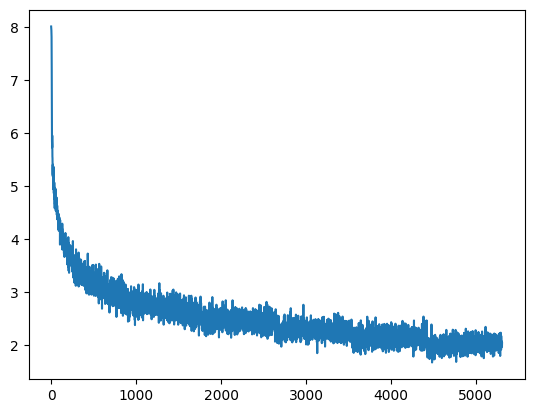

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

# Test

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Testing:   0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evalu

Average Test Loss: 2.3719920558253613
Corpus BLEU-4 Score: 0.09941091228838025
Average Sentence BLEU-4 Score: 0.04146689204895985


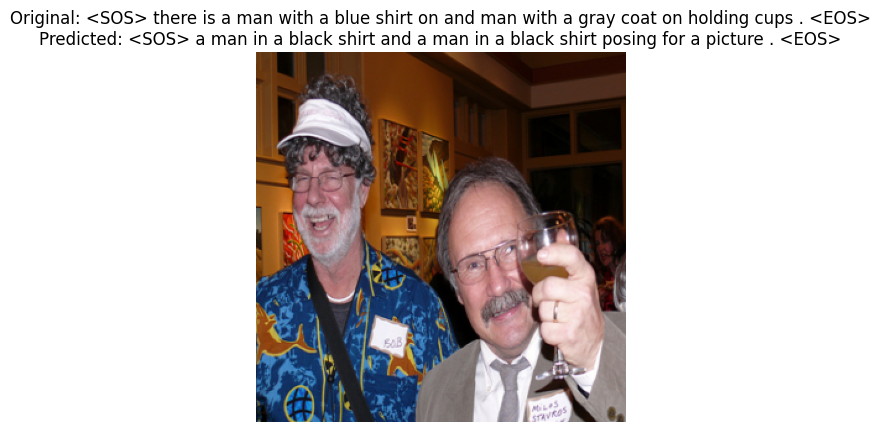

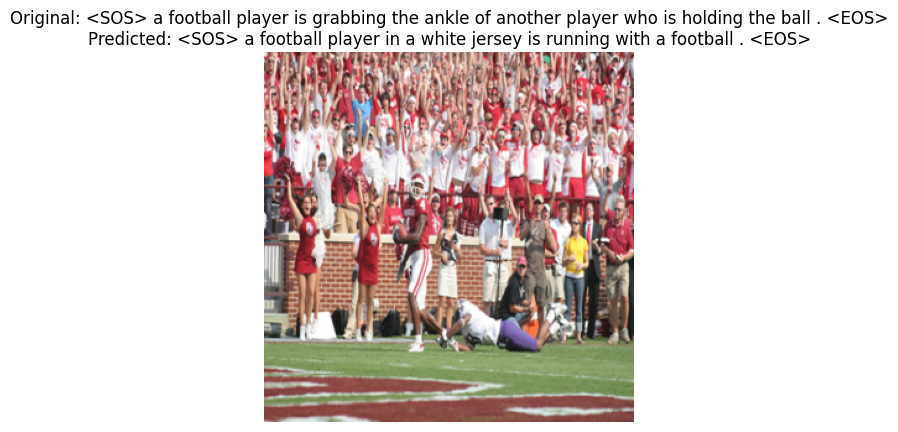

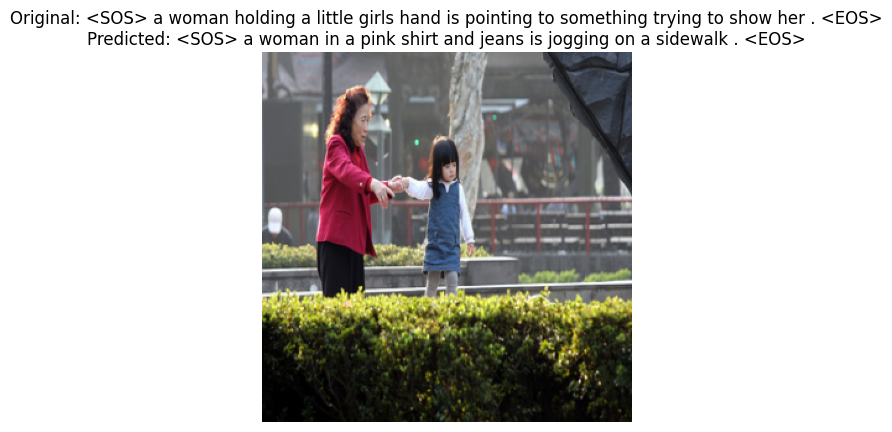

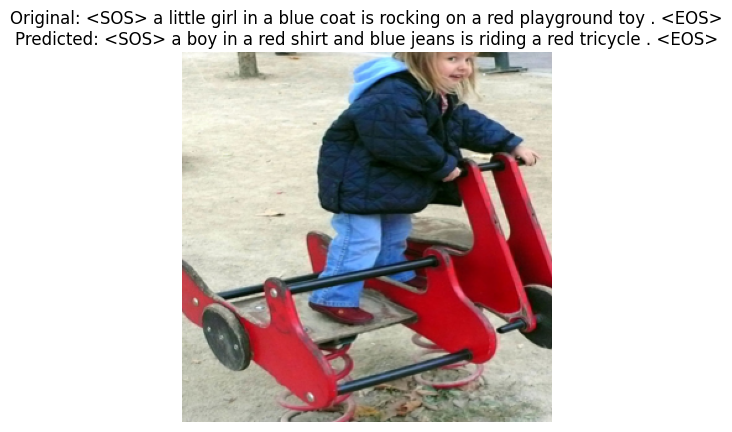

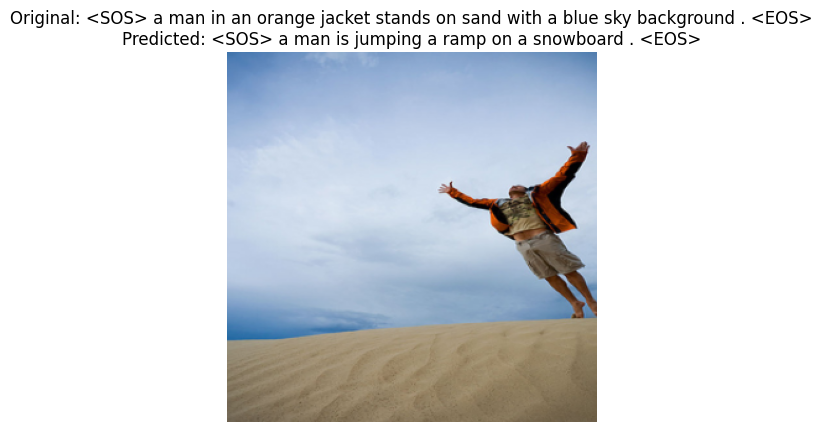

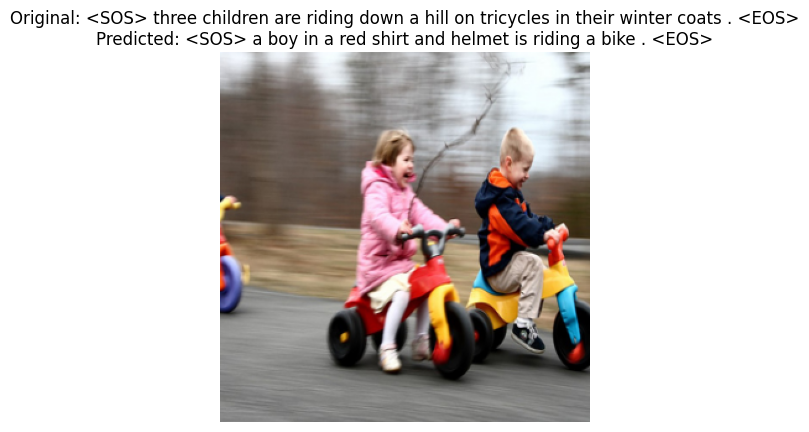

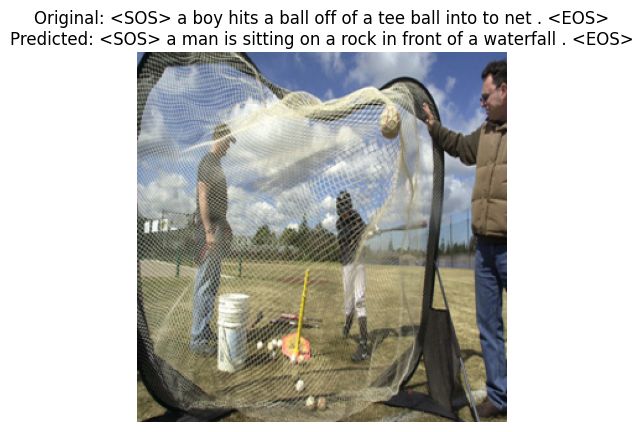

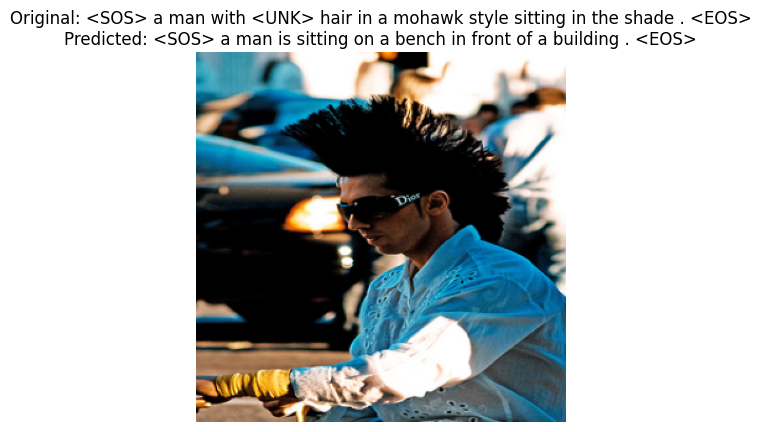

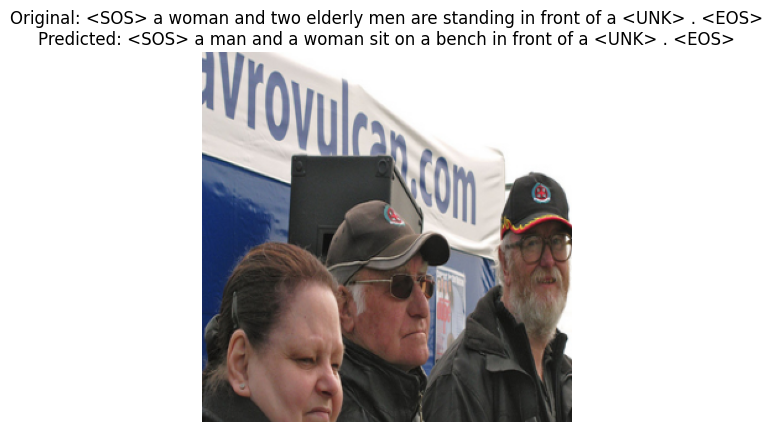

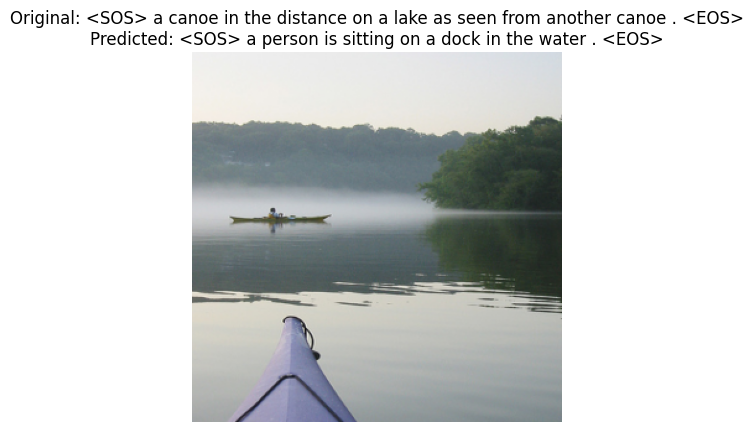

In [ ]:
# Define the test_model function
def test_model(model, dataloader, dataset, transform, device, criterion, num_samples=10):
    model.eval()
    model.to(device)

    total_loss = 0
    losses = []
    samples = []

    references = []  # For storing reference captions for BLEU score calculation
    hypotheses = []  # For storing predicted captions for BLEU score calculation
    sentence_bleu_scores = []  # For storing individual sentence BLEU score

    with torch.no_grad():
        for idx, (images, captions, lengths) in enumerate(tqdm(dataloader, desc="Testing")):
            images, captions = images.to(device), captions.to(device)
            features = model.encoder(images)
            batch_size = features.size(0)

            for i in range(batch_size):
                feature = features[i].unsqueeze(0)
                predicted_caption = model.decoder.caption_image(feature, dataset.vocab)
                original_caption = ' '.join(dataset.vocab.itos[idx.item()] if idx.item() in dataset.vocab.itos and dataset.vocab.itos[idx.item()] != '<PAD>' else "<UNK>" for idx in captions[i] if dataset.vocab.itos[idx.item()] != '<PAD>')
                image_np = images[i].cpu().numpy()
                image_np = np.transpose(image_np, (1, 2, 0))  # Change to (height, width, channels)
                image_np = (image_np * 0.5) + 0.5  # Denormalize the image

                samples.append((image_np, original_caption, predicted_caption))
                references.append([original_caption.split()])  # Reference caption for BLEU score
                hypotheses.append(predicted_caption)  # Predicted caption for BLEU score

                # Calculate sentence BLEU score for this caption
                sentence_bleu_temp = sentence_bleu([original_caption.split()], predicted_caption)
                sentence_bleu_scores.append(sentence_bleu_temp)

            # Calculate loss for this batch
            outputs = model(images, captions, lengths)
            packed = pack_padded_sequence(captions, lengths, batch_first=True)
            targets, _ = packed.data, packed.batch_sizes

            loss = criterion(outputs, targets)
            total_loss += loss.item()
            losses.append(loss.item())

    average_loss = total_loss / len(dataloader)
    print(f"Average Test Loss: {average_loss}")

    # Compute BLEU scores using NLTK
    corpus_bleu_score = corpus_bleu(references, hypotheses)
    average_sentence_bleu_score = sum(sentence_bleu_scores) / len(sentence_bleu_scores)

    print(f"Corpus BLEU-4 Score: {corpus_bleu_score}")
    print(f"Average Sentence BLEU-4 Score: {average_sentence_bleu_score}")

    # Display some of the images and their captions
    for image_np, original_caption, predicted_caption in samples[:10]:
        plt.imshow(image_np)
        plt.axis('off')
        plt.title(f"Original: {original_caption}\nPredicted: {' '.join(predicted_caption)}")
        plt.show()

    return losses, corpus_bleu_score, average_sentence_bleu_score

# Assuming model, val_dataloader, dataset, transform, device, criterion are defined
test_losses, corpus_bleu_score, average_sentence_bleu_score = test_model(model, test_loader, test_dataset, transform, device, criterion, num_samples=10)

# Test loss

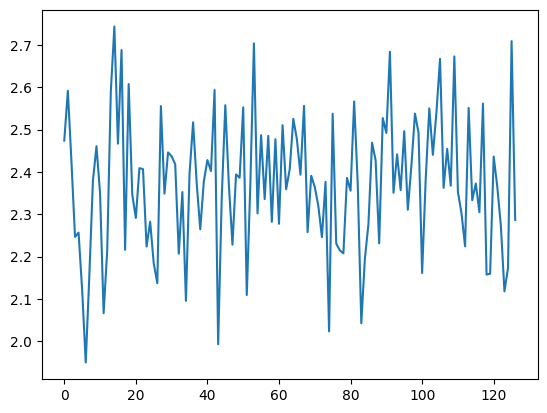

In [ ]:
plt.plot(test_losses)